## **CRIANDO O EFEITO DE MINIATURA A IMAGENS** ##

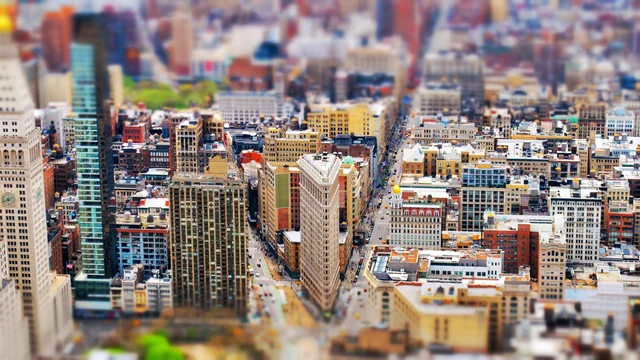

# Como funciona em câmeras
- Tilt (inclinação): Ajusta o ângulo do plano da lente em relação ao sensor da câmera. Isso altera a profundidade de campo, mantendo apenas uma parte da imagem em foco e desfocando gradualmente o restante.
- Shift (deslocamento): Move a lente paralelamente ao sensor para corrigir distorções de perspectiva, geralmente útil para fotografia de arquitetura.

# Como replicar no OpenCV
1. Criar uma mascara para desfoque seletivo.
2. Aplicar o desfoque Gaussiano
3. Combinar a imagem nítida e desfocada usando a máscara

In [8]:
#IMPORTAÇÕES 

import cv2
import sys
import numpy as np
import math
import os
import scipy.signal
import shutil
from matplotlib import pyplot as plt


In [9]:
#NOSSA FUNÇÃO DE LEITURA DE IMAGEM

def imshow(title = 'Image', image = None, size = 10):
    w, h = image.shape[0], image.shape[1]
    aspectRatio = w/h
    plt.figure(figsize=(size * aspectRatio))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.show()

In [10]:
#Criando kernel para aplicação de convolução
#Recebe no parametro um valor float entre 0 e 1.
#Retorna numpy.ndarray de 5x5

def gerandoKernel(parametro):
    #Valores próximos de 0 geram uma matriz mais uniforme, com menor peso central.
    #Valores próximos de 1 criam um kernel com um peso central forte, simulando um filtro de destaque localizado.
    kernel = np.array([0.25 - parametro / 2.0, 0.25, parametro, 0.25, 0.25 - parametro / 2.0])
    print("Kernel criado", kernel)
    """ 
    np.outer() calcula o produto externo entre os vetores. Isso cria uma matriz 5x5, onde cada elemento é o produto dos elementos correspondentes no vetor.
    A matriz resultante é simétrica, com valores que suavizam gradualmente em torno do centro, dependendo de parameter.
    Neste caso, cada valor é multiplicado por todos. Ou seja, geramos 25 valores a partir de 5.
    """
    return np.outer(kernel, kernel)

gerandoKernel(0.4)

Kernel criado [0.05 0.25 0.4  0.25 0.05]


array([[0.0025, 0.0125, 0.02  , 0.0125, 0.0025],
       [0.0125, 0.0625, 0.1   , 0.0625, 0.0125],
       [0.02  , 0.1   , 0.16  , 0.1   , 0.02  ],
       [0.0125, 0.0625, 0.1   , 0.0625, 0.0125],
       [0.0025, 0.0125, 0.02  , 0.0125, 0.0025]])

In [11]:
# Fazendo a convolução da imagem, gerando um kernel a partir do parametro 0.4 e reduzindo por 2 o tamanho

#Recebe como parametro image (numpy.ndarray): a grayscale image of shape (rows, columns)
def reduzindoImage(imagem):
    kernel = gerandoKernel(0.4)

    #fazendo a convolução
    """ 
    O parametro 'same' mantem a saida igual da imagem de entrada.
    """
    saida = scipy.signal.convolve2d(imagem, kernel, 'same')
    print(f"Tamanho original da imagem {saida.shape[0], saida.shape[1]}") #Tamanho original da imagem
    """ 
    A operação de slicing saida[::2, ::2] seleciona um pixel a cada dois em ambas as direções (horizontal e vertical).
    Ou seja, na primeira dimensão (linhas) ir de 2 em 2. e na segunda dimensão (colunas) ir de 2 em 2.
    """
    novaImagem = saida[:saida.shape[0]:2, :saida.shape[1]:2]
    print(f"Imagem reduzida {novaImagem.shape}") #Tamanho reduzido
    return novaImagem

#imagem = cv2.imread('images/original/city.jpg', 0)

#reduzindoImage(imagem)

In [12]:
def expandirImagem(imagem):
    #Recebe uma imagem em cinza
    #Retorna o dobro do tamanho

    #gerando o kernel
    kernel = gerandoKernel(0.4)

    #gerando imagem vazia com o dobro do tamanho
    saida = np.zeros((imagem.shape[0] * 2, imagem.shape[1] * 2))
    saida[:saida.shape[0]:2, :saida.shape[1]:2] = imagem

    #usando a convolução 
    saida = scipy.signal.convolve2d(saida, kernel, 'same')  * 4

imagem = cv2.imread('images/original/city.jpg', 0)
expandirImagem(imagem)

Kernel criado [0.05 0.25 0.4  0.25 0.05]


In [13]:
#Construa uma pirâmide de redução a partir da imagem, reduzindo-a pelo número de níveis passados ​​pela entrada.
def piramideGaussiana(imagem, niveis):
    #A imagem deve ser em cinza
    # niveis valor int. Valor positivo. Se for nivel 0, é a propria imagem sem redução. Se for valor 1 por exemplo, uma redução.
    # o retorno deve ser uma lista de numpy.ndarrays. Na primeira posição, a imagem original, e nas posições seguintes, as reduções realizadas. 

    saida = [imagem]

    for nivel in range(niveis):
        print(f"Nivel da piramide Gauss {nivel}")
        saida.append(reduzindoImage(saida[nivel]))
    
    return saida

imagem = cv2.imread('images/original/city.jpg', 0)
g = piramideGaussiana(imagem, 3)


Nivel da piramide Gauss 0
Kernel criado [0.05 0.25 0.4  0.25 0.05]
Tamanho original da imagem (659, 1024)
Imagem reduzida (330, 512)
Nivel da piramide Gauss 1
Kernel criado [0.05 0.25 0.4  0.25 0.05]
Tamanho original da imagem (330, 512)
Imagem reduzida (165, 256)
Nivel da piramide Gauss 2
Kernel criado [0.05 0.25 0.4  0.25 0.05]
Tamanho original da imagem (165, 256)
Imagem reduzida (83, 128)


In [14]:
#Piramide Laplaciana

#Recebe como entrada a piramide de redução. 
#Saida é uma lista de imagens, igual na piramide guassiana, cada nivel, contem a diferença entre duas camadas da piramide gaussiana. 
def piramideLaplaciana(piramideGaussiana):

    saida = []
    #Começando das 2 de baixo (maiores)
    # Nota: examine as listas, mas ignore o último elemento, pois não pode ser subtraído
    for imagem1, imagem2 in zip(piramideGaussiana[:-1], piramideGaussiana[1:]):
        # adicionar a diferença
        # Expandir a segunda e subtrair com a imagem maior (anterior da piramide)
        saida.append(imagem1 - expandirImagem(imagem2)[:imagem1.shape[0], :imagem1.shape[1]])
        
        
    saida.append(piramideGaussiana[-1])
    
    return saida

piramideLaplaciana(g)

Kernel criado [0.05 0.25 0.4  0.25 0.05]


TypeError: 'NoneType' object is not subscriptable

In [27]:
#Misture as duas pirâmides laplacianas ponderando-as de acordo com a máscara gaussiana.
# As pirâmides terão o mesmo número de níveis. Além disso, é garantido que cada camada tenha o mesmo formato dos níveis anteriores.
""" 
Você deve retornar uma pirâmide Laplaciana que tenha as mesmas dimensões da pirâmides de entrada. 
Cada camada deve ser uma mistura alfa do correspondente camadas das pirâmides de entrada, ponderadas pela máscara gaussiana. 
Isto significa o seguinte cálculo para cada camada da pirâmide:

saída[i, j] = máscara_atual[i, j] * imagem_branca[i,j] + (1 - máscara_atual[i, j]) * imagem_preta[i, j]

A multiplicação por piramideGaussiana controla quais partes da imagem lapBranca contribuem para a mistura.
A multiplicação por (1 - piramideGaussiana) controla quais partes da imagem lapPreta são usadas.

Portanto:
    Pixels onde current_mask == 1 devem ser retirados completamente da imagem branca.
    Pixels onde current_mask == 0 devem ser retirados completamente da imagem preta.
    Pixels intermediarios entre os dois valores, são a transição suave
"""

def misturasLaplacianas(lapBranca, lapPreta, piramideGaussiana):
    # lapBranca = Uma pirâmide laplaciana de uma imagem
    # lapPreta = Uma pirâmide laplaciana de outra imagem
    # piramideGaussiana = uma piramide gauss para mascara.

    piramideMisturada = []
    #Itera sobre os níveis correspondentes das pirâmides
    for lapBranca, lapPreta, piramideGaussiana in zip(lapBranca, lapPreta, piramideGaussiana):
        piramideMisturada.append(piramideGaussiana * lapBranca + (1 - piramideGaussiana) * lapPreta)

    # O resultado é uma imagem que combina ambas as imagens de entrada de forma suave, conforme especificado pela máscara em piramideGaussiana.
    return piramideMisturada

In [ ]:
def colapsandoPiramide(piramide):
    """ 
    Começando na menor camada da pirâmide. Expanda a menor camada e adicione-a à segunda menor camada. 
    Em seguida, expanda a segunda camada para a menor e continue o processo até chegar à imagem maior. 
    """

    saida = piramide[:-1]

    for imagem in reversed(piramide[:-1]):
        saida = imagem + expandirImagem(saida)[:imagem.shape[0], :imagem.shape[1]]
    
    return saida